In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.statespace.tools as tools
import statsmodels.tsa.tsatools as ts

In [2]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, regression='ct', autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [3]:
data0=pd.read_excel("pr.xlsx")
data = data0.copy()
data['dateid01']= pd.to_datetime(data['dateid01'], dayfirst=True)
data.set_index('dateid01', inplace=True)
data.asfreq('M')
data.index = data.index.to_period('M')
print('rows:',data.shape[0])
print('columns:',data.shape[1])
print(data)

rows: 235
columns: 4
                dp        dr         p         r
dateid01                                        
1990-05   0.000000  0.000000  4.152613  3.901973
1990-06  -0.016647  0.025923  4.135966  3.927896
1990-07  -0.105449  0.019494  4.030517  3.947390
1990-08  -0.026280  0.015326  4.004237  3.962716
1990-09   0.078710  0.042797  4.082947  4.005513
...            ...       ...       ...       ...
2009-07  -0.061171 -0.095310  1.684545  2.397895
2009-08  -0.011194 -0.146603  1.673351  2.251292
2009-09  -0.011321 -0.043018  1.662030  2.208274
2009-10  -0.036719 -0.193371  1.625311  2.014903
2009-11   0.084877  0.125163  1.710188  2.140066

[235 rows x 4 columns]


In [16]:
y=np.array(data.iloc[:,2:3])
x=np.array(data.iloc[:,-1:])

### Testing y With ADF

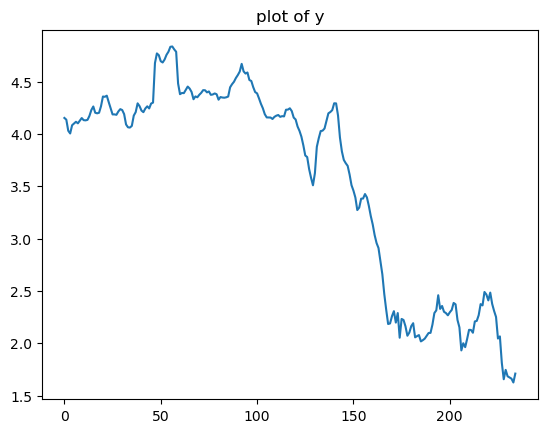

Results of Dickey-Fuller Test:
Test Statistic                  -1.892165
p-value                          0.658720
#Lags Used                      12.000000
Number of Observations Used    222.000000
Critical Value (1%)             -4.000139
Critical Value (5%)             -3.430454
Critical Value (10%)            -3.138779
dtype: float64
None


In [17]:
plt.plot(y)
plt.title('plot of y')
plt.show()
print(adf_test(y))

### Testing x With ADF

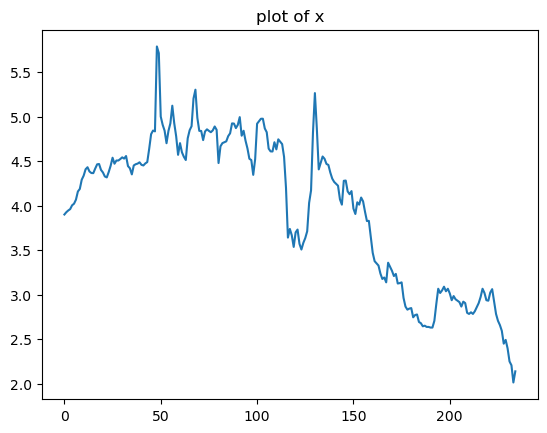

Results of Dickey-Fuller Test:
Test Statistic                  -2.221954
p-value                          0.477505
#Lags Used                      15.000000
Number of Observations Used    219.000000
Critical Value (1%)             -4.000714
Critical Value (5%)             -3.430730
Critical Value (10%)            -3.138940
dtype: float64
None


In [18]:
plt.plot(x)
plt.title('plot of x')
plt.show()
print(adf_test(x))

### Testing dy With ADF

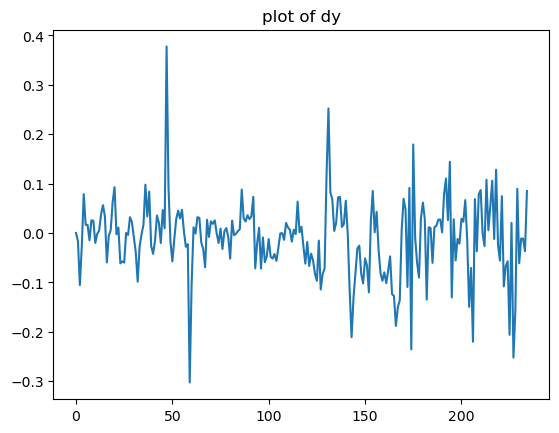

Results of Dickey-Fuller Test:
Test Statistic                  -3.847008
p-value                          0.014327
#Lags Used                      15.000000
Number of Observations Used    219.000000
Critical Value (1%)             -4.000714
Critical Value (5%)             -3.430730
Critical Value (10%)            -3.138940
dtype: float64
None


In [19]:
dy=tools.diff(y,k_diff=1, k_seasonal_diff=None, seasonal_periods=None)
dy=np.insert(dy,0,0)
plt.plot(dy)
plt.title('plot of dy')
plt.show()
print(adf_test(dy))

### Testing dx With ADF

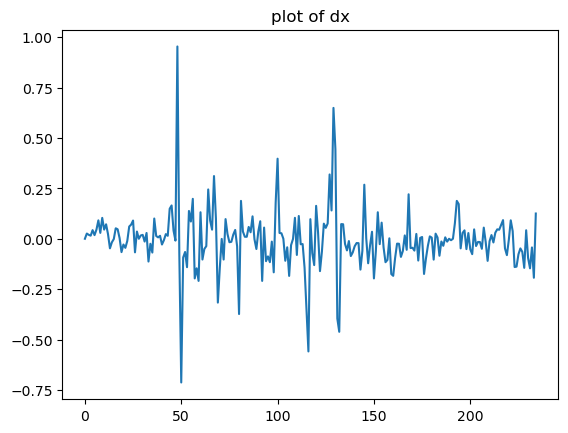

Results of Dickey-Fuller Test:
Test Statistic                -6.340479e+00
p-value                        4.114728e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.200000e+02
Critical Value (1%)           -4.000520e+00
Critical Value (5%)           -3.430637e+00
Critical Value (10%)          -3.138886e+00
dtype: float64
None


In [20]:
dx=tools.diff(x, k_diff=1,k_seasonal_diff=None, seasonal_periods=None)
dx=np.insert(dx,0,0)
plt.plot(dx)
plt.title('plot of dx')
plt.show()
print(adf_test(dx))

In [21]:
#long run regression
X=sm.add_constant(x)
model_lr=sm.OLS(y,X).fit()
print(model_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1812.
Date:                Fri, 19 May 2023   Prob (F-statistic):          6.93e-112
Time:                        11:51:00   Log-Likelihood:                -72.811
No. Observations:                 235   AIC:                             149.6
Df Residuals:                     233   BIC:                             156.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8239      0.105     -7.824      0.0

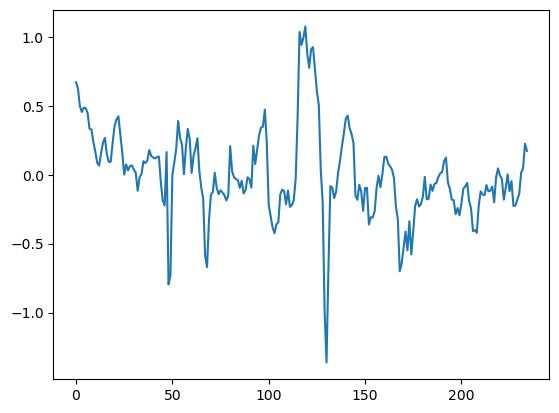

In [22]:
# taking residauls of long run regression
residual=model_lr.resid
plt.plot(residual)
plt.show()

### Testing Residuals With ADF

In [26]:
#testing cointegration

'''testing whether there is or not unit root in residuals of long run regression'''

print(adf_test(residual))

Results of Dickey-Fuller Test:
Test Statistic                  -5.493275
p-value                          0.000024
#Lags Used                       3.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.998505
Critical Value (5%)             -3.429669
Critical Value (10%)            -3.138318
dtype: float64
None


In [27]:
#taking lag of residual
resid_lag_1=ts.lagmat(residual, maxlag=1)

In [28]:
#short run regression
dX=sm.add_constant(dx)
exog=np.column_stack((dX,resid_lag_1))
model_sr=sm.OLS(dy,exog).fit()
print(model_sr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     7.255
Date:                Fri, 19 May 2023   Prob (F-statistic):           0.000879
Time:                        11:55:00   Log-Likelihood:                 277.13
No. Observations:                 235   AIC:                            -548.3
Df Residuals:                     232   BIC:                            -537.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0100      0.005     -2.041      0.0